# 一、项目背景介绍
该项目为推荐系统deepFM算法模型

# 二、数据介绍
数据集有用户ID,离散标签，连续标签和预测标签组成，如[ID,预测标签，I1,I2,..I13,C1,C2,...C26]
![](https://ai-studio-static-online.cdn.bcebos.com/1fa1d2ab991a479e90c40e517181e91c065dbbd998dd4f53897d54cc0c5ec1dd)


# 模型介绍
![](https://ai-studio-static-online.cdn.bcebos.com/c52751045c0c4a40a7da439bf957379251b8b230d98d4aae9cfc5428bf5b56b2)

DeepFM由两部分组成:神经网络部分和因子分解部分，分别负责提取低阶特征和高阶特征。这两部分共享相同的输入。DeepFM的预测结果可以写成:
![](https://ai-studio-static-online.cdn.bcebos.com/bc24106d65de471285fd3c2c5838bd6f067f28d37c14476ab4b86c09582b947b)




# 四、模型训练

(由于时间太赶，代码还没排版好，下次有时间再重新整理一下代码)

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path="./preprocess data/"

In [3]:
def prepared_data(file_path):
    # 读入训练集， 验证集和测试集
    train = pd.read_csv(file_path + 'train_set.csv')
    val = pd.read_csv(file_path + 'val_set.csv')
    test = pd.read_csv(file_path + 'test_set.csv')
    
    trn_x, trn_y = train.drop(columns='Label').values, train['Label'].values
    val_x, val_y = val.drop(columns='Label').values, val['Label'].values
    test_x = test.values
    
    fea_col = np.load(file_path + 'fea_col.npy', allow_pickle=True)
    
    return fea_col, (trn_x, trn_y), (val_x, val_y), test_x

In [5]:
fea_cols, (trn_x, trn_y), (val_x, val_y), test_x = prepared_data(data_path)

In [13]:
fea_cols[0],fea_cols[1]

([{'feat': 'I1'},
  {'feat': 'I2'},
  {'feat': 'I3'},
  {'feat': 'I4'},
  {'feat': 'I5'},
  {'feat': 'I6'},
  {'feat': 'I7'},
  {'feat': 'I8'},
  {'feat': 'I9'},
  {'feat': 'I10'},
  {'feat': 'I11'},
  {'feat': 'I12'},
  {'feat': 'I13'}],
 [{'feat': 'C1', 'feat_num': 79, 'embed_dim': 8},
  {'feat': 'C2', 'feat_num': 252, 'embed_dim': 8},
  {'feat': 'C3', 'feat_num': 1293, 'embed_dim': 8},
  {'feat': 'C4', 'feat_num': 1043, 'embed_dim': 8},
  {'feat': 'C5', 'feat_num': 30, 'embed_dim': 8},
  {'feat': 'C6', 'feat_num': 7, 'embed_dim': 8},
  {'feat': 'C7', 'feat_num': 1164, 'embed_dim': 8},
  {'feat': 'C8', 'feat_num': 39, 'embed_dim': 8},
  {'feat': 'C9', 'feat_num': 2, 'embed_dim': 8},
  {'feat': 'C10', 'feat_num': 908, 'embed_dim': 8},
  {'feat': 'C11', 'feat_num': 926, 'embed_dim': 8},
  {'feat': 'C12', 'feat_num': 1239, 'embed_dim': 8},
  {'feat': 'C13', 'feat_num': 824, 'embed_dim': 8},
  {'feat': 'C14', 'feat_num': 20, 'embed_dim': 8},
  {'feat': 'C15', 'feat_num': 819, 'embed_dim'

In [17]:
import paddle
import paddle.nn as nn
from paddle.io import Dataset

In [18]:
#构建数据集

# 自定义数据集
#映射式(map-style)数据集需要继承paddle.io.Dataset
class SelfDefinedDataset(Dataset):
    def __init__(self, data_x, data_y, mode = 'train'):
        super(SelfDefinedDataset, self).__init__()
        self.data_x = data_x
        self.data_y = data_y
        self.mode = mode

    def __getitem__(self, idx):
        if self.mode == 'predict':
           return self.data_x[idx]
        else:
           return self.data_x[idx], self.data_y[idx]

    def __len__(self):
        return len(self.data_x)

In [21]:
dl_train_dataset=SelfDefinedDataset(trn_x, trn_y)
dl_val_dataset=SelfDefinedDataset(val_x, val_y)

In [22]:
for data, label in dl_train_dataset:
    print(data.shape, label.shape)
    print(data, label)
    break

(39,) ()
[9.47368421e-02 3.81388253e-04 8.27716684e-04 8.04597701e-02
 1.21156602e-04 1.50927124e-03 5.42822678e-03 9.14076782e-03
 1.24179528e-03 2.50000000e-01 2.70270270e-02 0.00000000e+00
 9.09090909e-03 2.60000000e+01 1.20000000e+01 7.50000000e+01
 3.93000000e+02 1.00000000e+00 0.00000000e+00 9.69000000e+02
 2.70000000e+01 1.00000000e+00 8.55000000e+02 3.32000000e+02
 6.59000000e+02 5.09000000e+02 1.30000000e+01 2.73000000e+02
 2.65000000e+02 8.00000000e+00 1.88000000e+02 2.30000000e+01
 2.00000000e+00 1.03300000e+03 0.00000000e+00 0.00000000e+00
 6.70000000e+01 2.70000000e+01 4.25000000e+02] 0


In [24]:
train_loader = paddle.io.DataLoader(dl_train_dataset, batch_size = 32, shuffle = True)
valid_loader = paddle.io.DataLoader(dl_val_dataset, batch_size = 32, shuffle = True)

In [25]:

for x, y in iter(train_loader):
    print(x.shape, y)
    break

[32, 39] Tensor(shape=[32], dtype=int64, place=CPUPlace, stop_gradient=True,
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0])


# 构建模型
这个模型是两部分组成， 左边是FM模型， 右边是DNN模型

![](https://ai-studio-static-online.cdn.bcebos.com/a1b104bf5d3e42dd83280daf98f5741217ce81455ae34cc1ba9015b5a7fdccac)


##FM公式
(![](https://ai-studio-static-online.cdn.bcebos.com/256411e6caa2444b9408dabc45686f8169e8be0fe60e41c1b9cb4eba2554b772))


In [108]:
class FM(nn.Layer):
    def __init__(self,dim,fea_num):
        super(FM,self).__init__()
        self.dim = dim
        self.w0 = self.create_parameter(paddle.zeros(shape=[1,]).shape)
        self.add_parameter('w0',self.w0)
        self.w1=self.create_parameter(paddle.rand(shape=[fea_num, 1]).shape)
        self.add_parameter('w1',self.w1)
        self.w2 = self.create_parameter(paddle.rand(shape=[fea_num, dim]).shape)
        self.add_parameter('w2',self.w2)
        
        


    def forward(self,inputs):
        
        first_order=self.w0+paddle.mm(inputs,self.w1)
        second_order = 1/2 * paddle.sum(
            paddle.pow(paddle.mm(inputs, self.w2), 2) - paddle.mm(paddle.pow(inputs,2), paddle.pow(self.w2, 2)),
            axis = 1,
            keepdim = True
        )

        return first_order + second_order
       
        

        


In [89]:
paddle.summary(FM(8,39),(32,39))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
     FM-18           [[32, 39]]            [32, 1]              352      
Total params: 352
Trainable params: 352
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
---------------------------------------------------------------------------



{'total_params': 352, 'trainable_params': 352}

In [91]:
s=FM(8,39)
for name, param in s.named_parameters():
    print(name, param)      

w0 Parameter containing:
Tensor(shape=[1], dtype=float32, place=CPUPlace, stop_gradient=False,
       [0.44599235])
w1 Parameter containing:
Tensor(shape=[39, 1], dtype=float32, place=CPUPlace, stop_gradient=False,
       [[ 0.15212154],
        [-0.23500401],
        [ 0.15196240],
        [-0.24409188],
        [ 0.33634973],
        [-0.25536168],
        [-0.38496849],
        [ 0.12309468],
        [ 0.08477345],
        [-0.28101498],
        [-0.31306419],
        [-0.24703261],
        [-0.32349095],
        [ 0.09884590],
        [ 0.10089105],
        [-0.16122256],
        [ 0.37944883],
        [-0.38282561],
        [-0.25189462],
        [ 0.23034543],
        [ 0.28095150],
        [-0.19442679],
        [ 0.31634802],
        [ 0.37122297],
        [-0.00535947],
        [ 0.02663028],
        [-0.33284673],
        [ 0.20504153],
        [ 0.14450914],
        [ 0.30093455],
        [ 0.30281061],
        [ 0.35462838],
        [ 0.23657298],
        [-0.07216120],
   

In [92]:
import paddle.nn.functional as F

In [103]:
class Dnn(nn.Layer):
    def __init__(self,hidden_list,dropout=0.):
        super(Dnn,self).__init__()
        self.dnn=nn.LayerList([nn.Linear(layer[0],layer[1]) 
          for layer in  list(zip(hidden_list[:-1],hidden_list[1:]))])
        self.dropout=nn.Dropout(dropout)
        

    def forward(self,x):
        for linear in self.dnn:
            x=linear(x)
            x=F.relu(x)

        self.dropout(x)
        
        
        return(x)
        


In [105]:
paddle.summary(Dnn([128, 64, 32]),(32,128))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Linear-28        [[32, 128]]            [32, 64]            8,256     
   Linear-29         [[32, 64]]            [32, 32]            2,080     
   Dropout-2         [[32, 32]]            [32, 32]              0       
Total params: 10,336
Trainable params: 10,336
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.03
Params size (MB): 0.04
Estimated Total Size (MB): 0.09
---------------------------------------------------------------------------



{'total_params': 10336, 'trainable_params': 10336}

In [106]:
z=Dnn([128, 64, 32])
for name, param in z.named_parameters():
    print(name, param)  

dnn.0.weight Parameter containing:
Tensor(shape=[128, 64], dtype=float32, place=CPUPlace, stop_gradient=False,
       [[ 0.06707515,  0.13847785, -0.06655482, ..., -0.16561088,
         -0.06180841,  0.15573387],
        [-0.09976895, -0.08881859, -0.02656919, ..., -0.05318263,
         -0.17018560,  0.15193240],
        [-0.00428711, -0.02451752,  0.16817419, ..., -0.05110016,
         -0.01681779, -0.11648417],
        ...,
        [ 0.09143643, -0.09313656, -0.12042940, ...,  0.13972722,
         -0.04550512, -0.05906151],
        [-0.09089268, -0.04715914, -0.14746152, ..., -0.07574488,
         -0.10247044,  0.17553581],
        [ 0.04491828, -0.04316257,  0.10424592, ..., -0.13233250,
         -0.07001856, -0.17624608]])
dnn.0.bias Parameter containing:
Tensor(shape=[64], dtype=float32, place=CPUPlace, stop_gradient=False,
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [195]:
class DeepFM(nn.Layer):
    def __init__(self,feature_columns,hidden_list,dnn_dropout=0.):
        super(DeepFM,self).__init__()
        self.dense_feature_cols, self.sparse_feature_cols = feature_columns
        
        #embedding
        self.embed_layers=nn.LayerDict({
            "embed_"+str(i):nn.Embedding(feat['feat_num'],feat['embed_dim'])   for i,feat in enumerate(self.sparse_feature_cols)
        })
        
        
        
        self.fea_num=len(self.dense_feature_cols)+len(self.sparse_feature_cols)*self.sparse_feature_cols[0]['embed_dim']
        hidden_list.insert(0,self.fea_num)
        self.fm=FM(self.sparse_feature_cols[0]['embed_dim'],self.fea_num)
        self.dnn_network=Dnn(hidden_list,dnn_dropout)
        self.nn_final_linear=nn.Linear(hidden_list[-1],1)
        
        
        
    def forward(self,x):
        dense_inputs,sparse_inputs = x[:,:len(self.dense_feature_cols)],x[:,len(self.dense_feature_cols):]
        sparse_inputs = paddle.cast(sparse_inputs, dtype='long')
        sparse_embeds=[self.embed_layers['embed_'+str(i)](sparse_inputs[:,i])  for i  in range(26)]
        # sparse_embeds=[self.embed_layers['embed_'+str(i)](sparse_inputs[:,i])  for i  in range(sparse_inputs.shape[1])]
        sparse_embeds=paddle.concat(sparse_embeds,axis=-1)
        
        #把离散特征和连续特征进行拼接作为FM和DNN的输入
        dense_inputs = paddle.cast(dense_inputs, dtype='float32')
        sparse_inputs = paddle.cast(sparse_inputs, dtype='float32')
        x=paddle.concat([sparse_embeds,dense_inputs],axis=-1)
        #wide
        wide_outputs=self.fm(x)
        #deep
        deep_outputs=self.nn_final_linear(self.dnn_network(x))
        
        #模型的输出
        outputs=F.sigmoid(paddle.add(wide_outputs,deep_outputs))
        
        return outputs
        
        
        

In [196]:
# 建立模型
hidden_list = [128, 64, 32]
dnn_dropout = 0.

model = DeepFM(fea_cols, hidden_list, dnn_dropout)

In [197]:
for fea,label in iter(train_loader):
    out=model(fea)
    print(out)
    break

Tensor(shape=[32, 1], dtype=float32, place=CPUPlace, stop_gradient=False,
       [[0.32315740],
        [0.31093273],
        [0.16905159],
        [0.19599071],
        [0.29962289],
        [0.29254788],
        [0.33215153],
        [0.24165253],
        [0.26359463],
        [0.24375126],
        [0.27597246],
        [0.26628450],
        [0.20531006],
        [0.26816389],
        [0.24701035],
        [0.23330608],
        [0.22911505],
        [0.22370060],
        [0.24913113],
        [0.22915682],
        [0.19512792],
        [0.27199194],
        [0.21131818],
        [0.18487053],
        [0.26939511],
        [0.22719760],
        [0.29795116],
        [0.20505209],
        [0.23758069],
        [0.17697102],
        [0.23378713],
        [0.27061450]])


In [198]:
paddle.summary(model, (trn_x.shape[1],128))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
 Embedding-445         [[39]]              [39, 8]              632      
 Embedding-446         [[39]]              [39, 8]             2,016     
 Embedding-447         [[39]]              [39, 8]            10,344     
 Embedding-448         [[39]]              [39, 8]             8,344     
 Embedding-449         [[39]]              [39, 8]              240      
 Embedding-450         [[39]]              [39, 8]              56       
 Embedding-451         [[39]]              [39, 8]             9,312     
 Embedding-452         [[39]]              [39, 8]              312      
 Embedding-453         [[39]]              [39, 8]              16       
 Embedding-454         [[39]]              [39, 8]             7,264     
 Embedding-455         [[39]]              [39, 8]             7,408     
 Embedding-456         [[39]]       

{'total_params': 145503, 'trainable_params': 145503}

In [205]:
from sklearn.metrics import roc_auc_score

In [206]:
def auc(y_pred,y_true):
    pred=y_pred
    y=y_true
    return roc_auc_score(y,pred)

loss_func=nn.BCELoss()
optimizer=paddle.optimizer.Adam(parameters=model.parameters(),learning_rate=0.001)
metric_func=auc
metric_name='auc'

In [210]:
#脚本风格
import datetime

epochs=10
log_step_freq=10

dfhistory=pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_'+metric_name])

print('start training----')
nowtime=datetime.datetime.now().strftime('%Y-%m-%d  %H:%M:%S')
print('======='*8+'%s'%nowtime)

for epoch in range(1,epochs+1):
    
    #训练阶段
    model.train()
    loss_sum=0.0
    metric_sum=0.0
    step=1
    
    for step,(features,labels) in enumerate(train_loader,1):
        #梯度清零
        optimizer.clear_grad()
        
        #正向传播
        predictions=model(features)
        predictions=predictions.squeeze(1)
        labels = paddle.cast(labels, dtype='float32')
        loss=loss_func(predictions,labels)
        try:
            metric=metric_func(predictions,labels)
            
        except ValueError:
            pass
        
        #反向传播
        loss.backward()
        optimizer.step()
        
        #打印出batch级日志
        
        loss_sum+=loss.item()
        metric_sum+=metric.item()
        
        if step%log_step_freq==0:
            print(("[step=%d] loss:%.3f,"+metric_name+":%.3f")%(step, loss_sum/step, metric_sum/step))

    
    #验证阶段
    model.eval()
    val_loss_sum=0.0
    val_metric_sum=0.0
    val_step=1
    
    for val_step,(features,labels) in enumerate(valid_loader,1):
        
            predictions=model(features)
            predictions=predictions.squeeze(1)
            labels = paddle.cast(labels, dtype='float32')
            val_loss=loss_func(predictions,labels)
            try:
                val_metric=metric_func(predictions,labels)
                
            except ValueError:
                pass
            
            val_loss_sum+=val_loss.item()
            val_metric_sum+=val_metric.item()
        
    #记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    print(("\nEPOCH=%d, loss=%.3f, " + metric_name + " = %.3f, val_loss=%.3f, " + "val_" + metric_name + " = %.3f") %info)
    nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print('\n' + '=========='* 8 + '%s' %nowtime)

     

start training----
========================================================2022-03-07  01:45:48
[step=10] loss:0.000,auc:1.000
[step=20] loss:0.000,auc:1.000
[step=30] loss:0.000,auc:1.000
[step=40] loss:0.000,auc:1.000

EPOCH=1, loss=0.000, auc = 1.000, val_loss=1.187, val_auc = 0.630

================================================================================2022-03-07 01:45:48
[step=10] loss:0.000,auc:1.000
[step=20] loss:0.000,auc:1.000
[step=30] loss:0.000,auc:1.000
[step=40] loss:0.000,auc:1.000

EPOCH=2, loss=0.000, auc = 1.000, val_loss=1.198, val_auc = 0.628

================================================================================2022-03-07 01:45:49
[step=10] loss:0.000,auc:1.000
[step=20] loss:0.000,auc:1.000
[step=30] loss:0.000,auc:1.000
[step=40] loss:0.000,auc:1.000

EPOCH=3, loss=0.000, auc = 1.000, val_loss=1.223, val_auc = 0.641

================================================================================2022-03-07 01:45:49
[step=10] loss:0.000,auc:1.0

# 五、模型评估

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


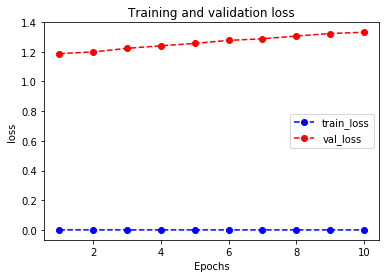

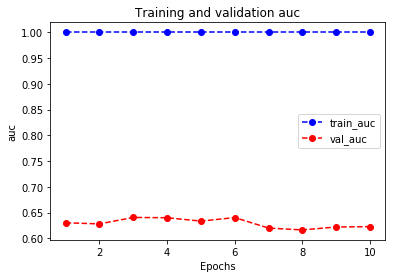

In [211]:
def plot_metric(dfhistory,metric):
    train_metric=dfhistory[metric]
    val_metric=dfhistory['val_'+metric]
    epochs=range(1,len(train_metric)+1)
    plt.plot(epochs,train_metric,'bo--')
    plt.plot(epochs,val_metric,'ro--')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
    
plot_metric(dfhistory,'loss')
plot_metric(dfhistory,'auc')

In [216]:
#预测
testx=paddle.to_tensor(test_x)
testx = paddle.cast(testx, dtype='float32')
y_pred_probs=model(testx)
y_pred_probs

Tensor(shape=[400, 1], dtype=float32, place=CPUPlace, stop_gradient=False,
       [[0.00698614],
        [0.99999368],
        [0.00000875],
        [0.00000774],
        [0.00059250],
        [0.55392522],
        [0.74556124],
        [0.00002774],
        [0.00008443],
        [0.00005355],
        [0.00002804],
        [0.15859747],
        [0.57526356],
        [0.00000017],
        [0.01397542],
        [0.00002751],
        [0.00001771],
        [0.99611890],
        [0.20293407],
        [0.91348392],
        [0.99476057],
        [0.00162912],
        [0.00048150],
        [0.00029815],
        [0.00116739],
        [0.00080913],
        [0.00001670],
        [0.00103130],
        [0.00000017],
        [0.00000461],
        [0.16735120],
        [0.03040477],
        [0.03635709],
        [0.10908052],
        [0.00112515],
        [0.04119326],
        [0.50048715],
        [0.00000039],
        [0.00019302],
        [0.00003949],
        [0.86209637],
        [0.06512322],
 

# 六、总结与升华

deepFM可以自己寻找特征再也不需要人工找特征，但是，也有可能找到的特征是噪音

# 七、个人总结

第一次利用paddle算法来做，若有错误之处，欢迎大家指出！
